# Exploring factors that affect the ridership
- Regression Analysis on various factors that may affect ridership
- Location information
- Distances to venues
- Weather

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.linear_model import LinearRegression, RANSACRegressor
%matplotlib inline

In [2]:
# Method for plotting regression results
def plot_MyLinearRegression(x, y, ax, xrange, ransac=False, loc='upper right', coeff=False,
                                                    xlabel=None, ylabel=None, title=None, xlim=None, ylim=None, fs=None):

    # Fit line using all data using regular Linear Regression
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)     # make x a vertical vector

    # Predict data of estimated models using simple LinearRegression
    line_X = np.arange(xrange[0], xrange[1], step=(xrange[1] - xrange[0])/20)
    line_y = model.predict(line_X[:, np.newaxis])
    if coeff:
        text_coeff = '(coeff = %.2f)' % model.coef_
    else:
        text_coeff = 'Fit'
    
    # Robustly fit linear model with RANSAC algorithm
    if ransac:
        model_ransac = RANSACRegressor(LinearRegression())
        model_ransac.fit(x.reshape(-1, 1), y)     # make x a vertical vector
        inlier_mask = model_ransac.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)

        line_y_ransac = model_ransac.predict(line_X[:, np.newaxis])
        if coeff:
            text_coeff_ransac = '(coeff = %.2f)' % model_ransac.estimator_.coef_
        else:
            text_coeff_ransac = ''

    lw = 3
    s=150
    
    # If the ransac parameter is True, plot RANSAC result
    if ransac:
        ax.scatter(x[inlier_mask], y[inlier_mask], s=s, color='blue', marker='.', label='Inliers', alpha=0.2)
        ax.scatter(x[outlier_mask], y[outlier_mask], s=s, color='yellowgreen', marker='.', label='Outliers', alpha=0.3)
        ax.plot(line_X, line_y, color='b', linestyle=':', linewidth=lw, label=('Linear ' + text_coeff), alpha=0.5)
        ax.plot(line_X, line_y_ransac, color='cornflowerblue', linestyle='--',linewidth=lw, label=('RANSAC ' + text_coeff_ransac), alpha=0.8)
    else:
        ax.scatter(x, y, s=s, color='blue', marker='.', alpha=0.2)
        ax.plot(line_X, line_y, color='b', linestyle=':', linewidth=lw, label=('Linear ' + text_coeff), alpha=0.5)
    
    ax.legend(loc=loc, fontsize=fs)
    ax.set_title(title, fontsize=fs)
    ax.set_xlabel(xlabel, fontsize=fs)
    ax.set_ylabel(ylabel, fontsize=fs)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

<b> Importing the datasets and comining into one</b>

In [3]:
# Import data for daily pickups
d1 = pd.read_csv('./data/processed/extended2/p_s_alltime_extended.csv')
d2 = pd.read_csv('./data/processed/extended2/p_ns_alltime_extended.csv')

In [4]:
# Combine the two sets and delete columns
data = pd.concat([d1, d2], axis=0)
del data['Unnamed: 0']
del data['DATE']

In [5]:
data.columns

Index(['date', 'pickups', 'st_id', 'st_name', 'st_latitude', 'st_longitude',
       'closest_college', 'closest_college_distance', 'closest_subway',
       'closest_subway_distance', 'closest_theater',
       'closest_theater_distance', 'closest_museum', 'closest_museum_distance',
       'closest_park_name', 'closest_park_distance', 'PRCP', 'SNOW', 'SNWD',
       'TMAX', 'TMIN', 'AWND'],
      dtype='object')

In [6]:
# Drop rows where average wind entry is invalid (e.g. -9999)
data = data[data['AWND'] >= 0]

In [7]:
data.head()

,date,pickups,st_id,st_name,st_latitude,st_longitude,closest_college,closest_college_distance,closest_subway,closest_subway_distance,...,closest_museum,closest_museum_distance,closest_park_name,closest_park_distance,PRCP,SNOW,SNWD,TMAX,TMIN,AWND
0,20130701,47,72,W 52 St & 11 Ave,40.767272,-73.993929,American Academy Mcallister Institute Of Funer...,0.449863,8th Ave & 50th St at NW corner,0.836766,...,Intrepid Sea-Air-Space Museum,0.648424,De Witt Clinton Park,0.190527,21.3,0.0,0.0,25.0,22.2,1.4
1,20130701,73,79,Franklin St & W Broadway,40.719116,-74.006667,Borough Of Manhattan Comm College (Cuny),0.438224,West Broadway & Franklin St at SW corner,0.012754,...,Jackie Robinson Museum,0.470931,GREENSTREET,0.154135,21.3,0.0,0.0,25.0,22.2,1.4
2,20130701,13,82,St James Pl & Pearl St,40.711174,-74.000165,Pace University / New York City Campus,0.390559,Centre St & Chambers St at SE corner,0.372382,...,South Street Seaport Museum,0.590027,James Madison Plaza,0.143915,21.3,0.0,0.0,25.0,22.2,1.4
3,20130701,19,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,Long Island University / Brooklyn Campus,0.970719,4th Ave & Pacific St at NE corner,0.176488,...,Museum of Contemporary African Diasporan Arts ...,0.224781,Brooklyn Academy Of Music,0.108015,21.3,0.0,0.0,25.0,22.2,1.4
4,20130701,47,116,W 17 St & 8 Ave,40.741776,-74.001497,New School University / Jazz And Contemporary ...,0.717327,8th Ave & 16th St at NW corner,0.062889,...,Rubin Museum of Art,0.368229,Dr. Gertrude B. Kelly Playground,0.170808,21.3,0.0,0.0,25.0,22.2,1.4


In [8]:
data.describe().round(2)

,date,pickups,st_id,st_latitude,st_longitude,closest_college_distance,closest_subway_distance,closest_theater_distance,closest_museum_distance,closest_park_distance,PRCP,SNOW,SNWD,TMAX,TMIN,AWND
count,927184.00,927184.00,927184.00,926658.00,926658.00,926658.00,926658.00,926658.00,926658.00,926658.00,927184.00,927184.00,927184.00,927184.00,927184.00,927184.00
mean,20151089.71,41.66,969.03,40.73,-73.98,0.66,0.28,1.12,0.66,0.15,2.70,1.34,10.23,18.39,10.28,2.33
std,11423.29,55.11,1129.51,0.03,0.02,0.42,0.23,1.27,0.63,0.03,7.61,12.26,48.83,9.91,9.19,1.01
min,20130701.00,1.00,72.00,40.52,-74.03,0.02,0.00,0.01,0.02,0.09,0.00,0.00,0.00,-9.30,-18.20,0.30
25%,20140816.00,6.00,315.00,40.71,-74.00,0.33,0.09,0.25,0.27,0.13,0.00,0.00,0.00,10.60,3.30,1.60
50%,20150924.00,19.00,430.00,40.73,-73.99,0.59,0.22,0.52,0.48,0.15,0.00,0.00,0.00,19.40,10.60,2.20
75%,20160716.00,57.00,532.00,40.75,-73.97,0.90,0.41,1.64,0.76,0.17,0.80,0.00,0.00,27.20,18.30,2.90
max,20170331.00,827.00,3456.00,40.80,-73.93,11.94,7.75,21.62,7.72,0.22,126.20,279.00,480.00,36.70,28.30,8.20


<b>Location vs Ridership</b>

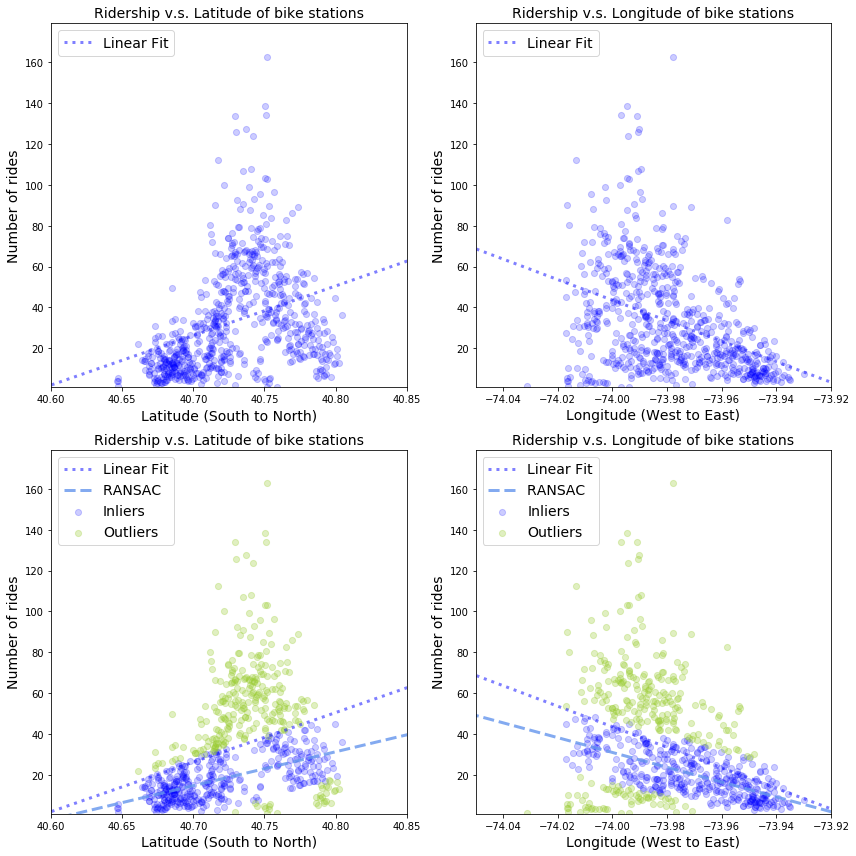

In [27]:
# Plot average daily ridership against latitude and longitude
data_lat = data[['st_latitude', 'pickups', 'st_id']].groupby(['st_id', 'st_latitude']).mean().reset_index()
data_long = data[['st_longitude', 'pickups', 'st_id']].groupby(['st_id', 'st_longitude']).mean().reset_index()

x_lat = np.array(data_lat['st_latitude']).reshape(-1, 1)
x_long = np.array(data_long['st_longitude']).reshape(-1, 1)

y_lat = np.array(data_lat['pickups']).reshape(-1, 1)
y_long = np.array(data_long['pickups']).reshape(-1, 1)

xrange_lat = [np.min(x_lat) - 1, np.max(x_lat) + 1]
xrange_long = [np.min(x_long) - 0.1, np.max(x_long) + 0.1]

xlabel_lat = 'Latitude (South to North)'
xlabel_long = 'Longitude (West to East)'
ylabel = 'Number of rides'
title_lat = 'Ridership v.s. Latitude of bike stations'
title_long = 'Ridership v.s. Longitude of bike stations'
ylim_lat = [0.8*np.min(y_lat), 1.1*np.max(y_lat)]
ylim_long = [0.8*np.min(y_long), 1.1*np.max(y_long)]


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12, 12), sharey=False)

plot_MyLinearRegression(x_lat, y_lat, ax1, ransac=False, loc='upper left',
                        xrange=xrange_lat, xlim=[40.6, 40.85], ylim=ylim_lat, 
                        xlabel=xlabel_lat, ylabel=ylabel, title=title_lat, fs=14)

plot_MyLinearRegression(x_long, y_long, ax2, ransac=False, loc='upper left',
                        xrange=xrange_long, xlim=[-74.05, -73.92], ylim=ylim_long, 
                        xlabel=xlabel_long, ylabel=ylabel, title=title_long, fs=14)

plot_MyLinearRegression(x_lat, y_lat, ax3, ransac=True, loc='upper left',
                        xrange=xrange_lat, xlim=[40.6, 40.85], ylim=ylim_lat, 
                        xlabel=xlabel_lat, ylabel=ylabel, title=title_lat, fs=14)

plot_MyLinearRegression(x_long, y_long, ax4, ransac=True, loc='upper left',
                        xrange=xrange_long, xlim=[-74.05, -73.92], ylim=ylim_long, 
                        xlabel=xlabel_long, ylabel=ylabel, title=title_long, fs=14)

plt.tight_layout()

<b> Distances to venues vs ridership</b>

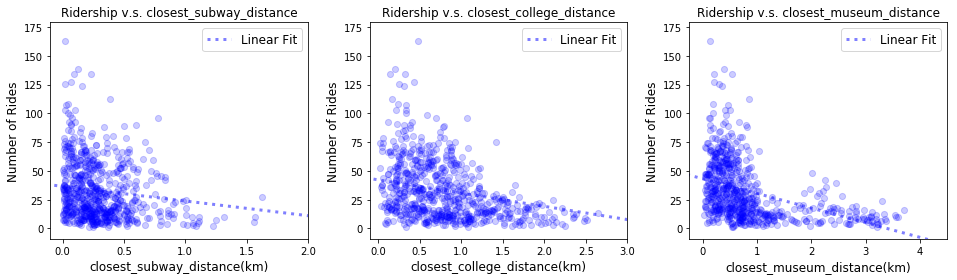

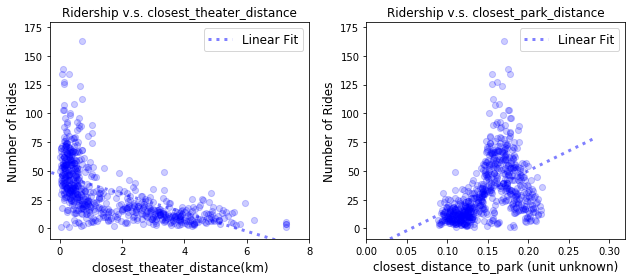

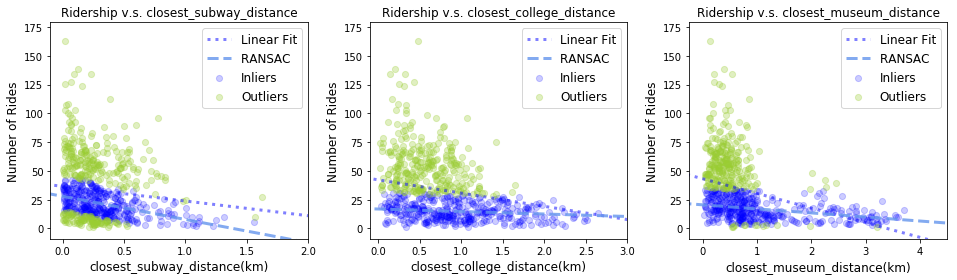

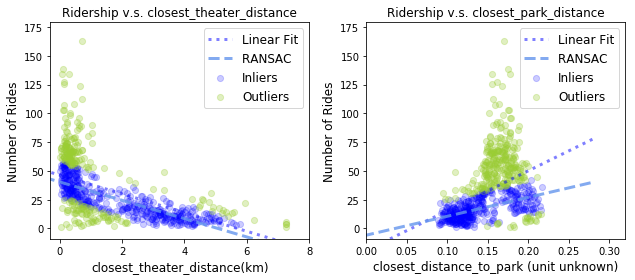

In [29]:
#plot ridership against distances to various kinds of venues

# set up a list containing relevant distances
vars1 = ['closest_subway_distance', 'closest_college_distance', 'closest_museum_distance', 
             'closest_theater_distance', 'closest_park_distance']

# Set up lists to contain data
xs = []
ys = []
xranges = []
xlims = []
xlim_mins = [-0.1, -0.1, -0.25, -0.3, 0.0]
xlim_maxes = [2.0, 3.0, 4.5, 8.0, 0.32]
ylims = []
xlabels = []
ylabel = 'Number of Rides'
titles = []

# Iterate over different variables
for i, var in enumerate(vars1):
    d = data[[var, 'pickups','st_id']].groupby([var, 'st_id']).mean().reset_index()
    x = np.array(d[var]).reshape(-1, 1)
    y = np.array(d['pickups']).reshape(-1, 1)
    
    xs.append(x)
    ys.append(y)
    xranges.append([-1, np.max(x)*1.2])
    xlims.append([xlim_mins[i], xlim_maxes[i]])
    ylims.append([-0.055*np.max(y), 1.1*np.max(y)])
    xlabels.append(var + '(km)')
    titles.append('Ridership v.s. ' + var)

# modify the parameters for park info
xranges[-1] = [-0.1, 0.3]
xlabels[-1] = 'closest_distance_to_park (unit unknown)'

# Plot Plain Linear Regression
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13.5, 4))
axes = [ax1, ax2, ax3]
for i in range(3):
    plot_MyLinearRegression(xs[i], ys[i], axes[i], ransac=False,
                                                 xrange=xranges[i], xlim=xlims[i], ylim=ylims[i], 
                                                 xlabel=xlabels[i], ylabel=ylabel, title=titles[i], fs=12)
plt.tight_layout()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
axes = [ax1, ax2]
for i in range(2):
    plot_MyLinearRegression(xs[i+3], ys[i+3], axes[i], ransac=False,
                                                 xrange=xranges[i+3], xlim=xlims[i+3], ylim=ylims[i+3], 
                                                 xlabel=xlabels[i+3], ylabel=ylabel, title=titles[i+3], fs=12)
plt.tight_layout()


# Plot RANSAC
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13.5, 4))
axes = [ax1, ax2, ax3]
for i in range(3):
    plot_MyLinearRegression(xs[i], ys[i], axes[i], ransac=True,
                                                 xrange=xranges[i], xlim=xlims[i], ylim=ylims[i], 
                                                 xlabel=xlabels[i], ylabel=ylabel, title=titles[i], fs=12)
plt.tight_layout()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
axes = [ax1, ax2]
for i in range(2):
    plot_MyLinearRegression(xs[i+3], ys[i+3], axes[i], ransac=True,
                                                 xrange=xranges[i+3], xlim=xlims[i+3], ylim=ylims[i+3], 
                                                 xlabel=xlabels[i+3], ylabel=ylabel, title=titles[i+3], fs=12)
plt.tight_layout()

<b>Weather correlation</b>

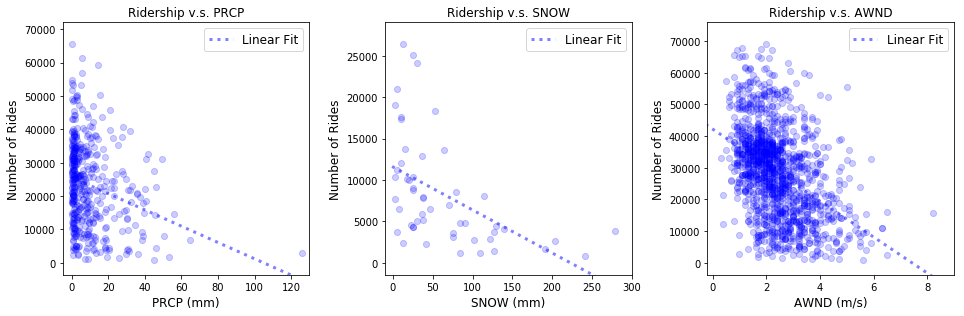

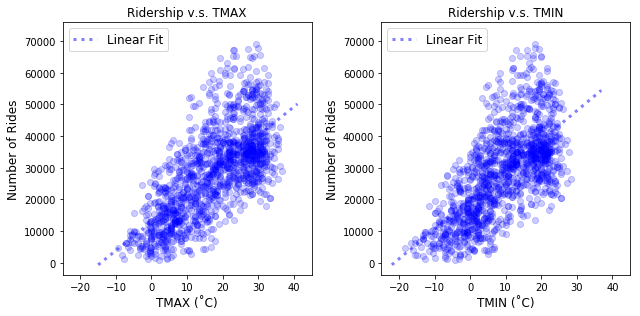

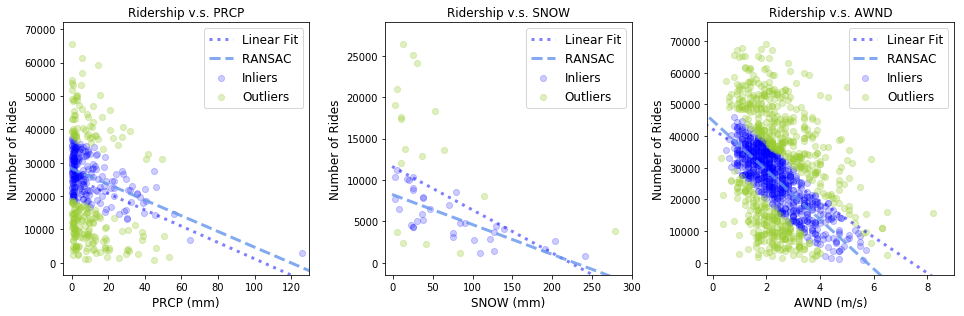

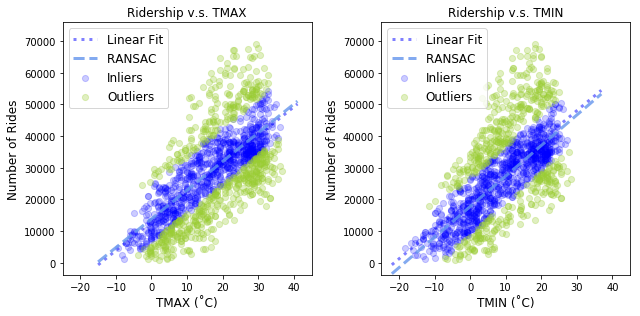

In [12]:
# Create a list of variables to iterate over
vars2 = ['PRCP', 'SNOW', 'AWND', 'TMAX', 'TMIN']
units = [' (mm)', ' (mm)', ' (m/s)', ' (˚C)', ' (˚C)']

# Set up lists to contain data
xs2 = []
ys2 = []
xranges2 = []
xlims2 = []
xlim_mins2 = [-5, -10, -0.2, -25, -25]
xlim_maxes2 = [130, 300, 9, 45, 45]
ylims2 = []
xlabels2 = []
ylabel2 = 'Number of Rides'
titles2 = []

# iterate over different variables
for i, var in enumerate(vars2):
    
    d = data[['date', 'pickups']].groupby('date').sum().reset_index()
    d = d.merge(data[['date', var]].drop_duplicates(), how='left', on='date')
    
    if (var == 'PRCP') | (var == 'SNOW'):
        d = d[d[var] != 0]
        
    x = np.array(d[var]).reshape(-1, 1)
    y = np.array(d['pickups']).reshape(-1, 1)
    
    xs2.append(x)
    ys2.append(y)
    xranges2.append([-1, np.max(x)*1.2])
    xlims2.append([xlim_mins2[i], xlim_maxes2[i]])
    ylims2.append([-0.055*np.max(y), 1.1*np.max(y)])
    xlabels2.append(var + units[i])
    titles2.append('Ridership v.s. ' + var)

xranges2[3] = [-15, 44]
xranges2[4] = [-22, 40]

# Plot Plain Linear Regression
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13.5, 4.5))
axes = [ax1, ax2, ax3]
for i in range(3):
    plot_MyLinearRegression(xs2[i], ys2[i], axes[i], ransac=False,
                                                 xrange=xranges2[i], xlim=xlims2[i], ylim=ylims2[i], 
                                                 xlabel=xlabels2[i], ylabel=ylabel2, title=titles2[i], fs=12)
plt.tight_layout()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5))
axes = [ax1, ax2]
for i in range(2):
    plot_MyLinearRegression(xs2[i+3], ys2[i+3], axes[i], ransac=False, loc='upper left',
                                                 xrange=xranges2[i+3], xlim=xlims2[i+3], ylim=ylims2[i+3], 
                                                 xlabel=xlabels2[i+3], ylabel=ylabel2, title=titles2[i+3], fs=12)
plt.tight_layout()


# Plot RANSAC
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13.5, 4.5))
axes = [ax1, ax2, ax3]
for i in range(3):
    plot_MyLinearRegression(xs2[i], ys2[i], axes[i], ransac=True,
                                                 xrange=xranges2[i], xlim=xlims2[i], ylim=ylims2[i], 
                                                 xlabel=xlabels2[i], ylabel=ylabel2, title=titles2[i], fs=12)
plt.tight_layout()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5))
axes = [ax1, ax2]
for i in range(2):
    plot_MyLinearRegression(xs2[i+3], ys2[i+3], axes[i], ransac=True, loc='upper left',
                                                 xrange=xranges2[i+3], xlim=xlims2[i+3], ylim=ylims2[i+3], 
                                                 xlabel=xlabels2[i+3], ylabel=ylabel2, title=titles2[i+3], fs=12)
plt.tight_layout()
